Machine Learning Course 2021-2022 By Dr. Nazerfard
* Exercise 4

* Question 4 - Reinforcement Learning (Policy-Iteration / Value-Iteration)

* By Gholamreza Dar 

* Winter 2022

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("dark")

import gym

from amalearn.agent import AgentBase
from amalearn.environment import EnvironmentBase

## Helper Functions

### Get Arrows

In [16]:
# Change this to change the obstacles in the world.
obstacles = np.array([
        # Bottom block
        [12, 6],
        [13, 6],
        [14, 6],
        [15, 6],
        [12, 7],
        [13, 7],
        [14, 7],
        [15, 7],

        # Top block
        [1, 7],
        [2, 7],
        [3, 7],
        [4, 7],
        [1, 8],
        [2, 8],
        [3, 8],
        [4, 8],

        # Right Block
        [8, 13],
        [8, 14],
        [8, 15],
        [9, 13],
        [9, 14],
        [9, 15],

        # Center Block
        # [7,7],
        # [7,8],
        # [8,7],
        # [8,8],

    ])

In [4]:
def get_arrow(action, m, n):
    '''Returns a string representing the arrow to be drawn for a given action.
    and '▇' if there is an obstacle.'''

    # list of arrows in 8 directions
    arrows = ['-', '→', '↘', '↓', '↙', '←', '↖', '↑', '↗']

    actions = np.array([
        [0, 0],   # stay
        [0, 1],   # E
        [1, 1],   # SE
        [1, 0],   # S
        [1, -1],  # SW
        [0, -1],  # W
        [-1, -1],  # NW
        [-1, 0],  # N
        [-1, 1]   # NE
    ])

    for j in range(0, len(obstacles)):
        if np.all(obstacles[j] == np.array([m+1, n+1])):
            return '▇'

    for i in range(len(actions)):
        if np.all(action == actions[i]):
            return arrows[i]


### Get Obstacles

In [5]:
def get_obstacle(m,n):
    ''' Returns a symbol for the cell at location (m, n).
    'S'   if its the starting state.
    'F'   if its the goal state.
    '▇ ' if its an obstacle.
    ' '   if its an empty cell.
    '''
    if m==0 and n==0:
        return 'F'
    elif m==14 and n==14:
        return 'S'

    for j in range(0, len(obstacles)):
        if np.all(obstacles[j] == np.array([m+1, n+1])):
            return '▇'
    return ' '

### Visualize Value Function

In [6]:
# Visualize V
def visualize_value_function(V, dpi=200, title=''):
    '''Visualizes the value function as a heatmap.'''
    
    fig, ax = plt.subplots(dpi=dpi)

    # Custom title
    if title != '':
        fig.suptitle(f'Value - {title}', fontsize=11, y=0.95)
    else:
        fig.suptitle('Value', fontsize=11, y=0.95)

    # Plot the V heatmap
    ax.matshow(V, cmap='YlOrRd_r')

    # Add the arrows
    for i in range(15):
        for j in range(15):
            text = f"{V[i,j]:.1f}"
            ax.text(j, i, text, va='center', ha='center', fontsize=4)
    
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()


### Visualize Policy

In [7]:
# Visualize Policy
def visualize_policy(V, policy, dpi=200, title=''):
    '''Visualizes the policy with arrows.'''
    
    plt.rcParams["font.family"] = "DejaVu Sans"

    fig, ax = plt.subplots(dpi=dpi)
    if title != '':
        fig.suptitle(f'Policy - {title}', fontsize=11, y=0.95)
    else:
        fig.suptitle('Policy', fontsize=11, y=0.95)

    # Plot the V heatmap
    ax.matshow(V, cmap='YlOrRd_r')

    for i in range(15):
        for j in range(15):
            text = get_arrow(policy[i, j], i, j)
            ax.text(j, i, text, va='center', ha='center')

    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()


### Visualize Path

In [8]:
# Visualize Policy
def visualize_path(V, policy, dpi=200, title=''):
    '''Visualizes the path with a line.'''

    plt.rcParams["font.family"] = "DejaVu Sans"

    # Custom title
    fig, ax = plt.subplots(dpi=dpi)
    if title != '':
        fig.suptitle(f'Path - {title}', fontsize=11, y=0.95)
    else:
        fig.suptitle('Path', fontsize=11, y=0.95)
    
    # Pathfinding (basically following the actions in the policy*)
    path = []
    current_state = np.array([15, 15])
    path.append(current_state)
    while not is_tuple_equal(current_state, np.array([1, 1])):
        action = policy[current_state[0]-1, current_state[1]-1]
        current_state = current_state + action
        path.append(current_state)

    # Plot the V heatmap
    ax.matshow(V, cmap='YlOrRd_r')

    # Plot the path
    path = np.array(path)
    ax.plot(path[:,1]-1, path[:,0]-1, '-o', color='springgreen', markersize=3)

    # visualize the obstacles as blocks
    for i in range(15):
        for j in range(15):
            c = get_obstacle(i, j)
            ax.text(j, i, c, va='center', ha='center')
    
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

    return path

### Visualize World

In [9]:
def render_world(current_state, policy=None, dpi=150, title=''):
    '''Displays The environment with the agent in 'current_state' location.
    Gets called every time the agent takes an action.
    '''

    # plt.rcParams["font.family"] = "Script MT"
    
    # Free Cells = 0.85
    world = np.ones((15, 15))*0.85

    # Obstacles = 0.20
    for j in range(len(obstacles)):
        world[obstacles[j][0]-1, obstacles[j][1]-1] = 0.20
    
    # The Agent = 0.60
    world[current_state[0]-1, current_state[1]-1] = 0.60

    # The Goal = 0.35
    world[0, 0] = 0.35

    # Plot the world
    # fig, ax = plt.subplots(dpi=dpi)
    
    plt.clf() # Clear the previous frame
    ax = plt.gca() # Get the current axis

    # Plot the world
    ax.matshow(world, cmap='bone', vmin=0, vmax=1)

    # Pathfinding (basically following the actions in the policy*)
    path = []
    current_state_tmp = current_state.copy()
    path.append(current_state_tmp)
    while not is_tuple_equal(current_state_tmp, np.array([1, 1])):
        action = policy[current_state_tmp[0]-1, current_state_tmp[1]-1]
        current_state_tmp = current_state_tmp + action
        path.append(current_state_tmp)

    # Plot the path
    path = np.array(path)
    ax.plot(path[:,1]-1, path[:,0]-1, color='springgreen', markersize=2, alpha=0.5)
    

    # Plot the borders
    ax.vlines(np.arange(0,16)-0.5, -0.5, 14.5, color='gray', linewidth=0.7, alpha=0.2)
    ax.hlines(np.arange(0,16)-0.5, -0.5, 14.5, color='gray', linewidth=0.7, alpha=0.2)

    # Display the Agent as 'A'
    ax.text(current_state[1]-1, current_state[0]-1, 'A', va='center', ha='center', fontsize=8)

    # Display the Agent as 'A'
    ax.text(0, 0, '$', va='center', ha='center', fontsize=8, color='white')

    plt.axis('off')
    plt.show()
    

### is_tuple_equal

In [10]:
def is_tuple_equal(t1, t2):
    '''Checks if two tuples of length=2 (can be an action or a state) are equal.'''

    return t1[0] == t2[0] and t1[1] == t2[1]


## Environment

In [11]:
class Environment(EnvironmentBase):
    def __init__(self, obstacles=None, id=0, action_count=9, actionPrice=-1, goalReward=100, punish=-10, j_limit=15, i_limit=15, p=0.8, container=None):

        # Define state_space and action_space required by the amalearn environment class
        state_space = gym.spaces.MultiDiscrete([i_limit, j_limit])
        action_space = gym.spaces.MultiDiscrete([3, 3])

        # Call the constructor
        super(Environment, self).__init__(
            action_space, state_space, id, container)

        # Get the environment variables (:D)
        self.action_price = actionPrice
        self.goal_reward = goalReward
        self.punish = punish
        self.p = p
        self.i_limit = i_limit
        self.j_limit = j_limit

        # Used to pass data between the environment and the agent
        self.optimal_policy = None
        self.optimal_V = None

        # Agent's Position at the start
        self.state = np.array([15, 15])

        # Get Obstacle positions
        self.obstacles = np.array([
            # Bottom block
            [12, 6],
            [13, 6],
            [14, 6],
            [15, 6],
            [12, 7],
            [13, 7],
            [14, 7],
            [15, 7],

            # Top block
            [1, 7],
            [2, 7],
            [3, 7],
            [4, 7],
            [1, 8],
            [2, 8],
            [3, 8],
            [4, 8],

            # Right Block
            [8, 13],
            [8, 14],
            [8, 15],
            [9, 13],
            [9, 14],
            [9, 15]
        ])

        self.all_actions = np.array([
            [0, 0],   # stay
            [0, 1],   # E
            [1, 1],   # SE
            [1, 0],   # S
            [1, -1],  # SW
            [0, -1],  # W
            [-1, -1],  # NW
            [-1, 0],  # N
            [-1, 1]   # NE
        ])

        # Override if custom obstacles is provided in the constructor
        if obstacles is not None:
            self.obstacles = obstacles

    # Done ✅✅
    def isStatePossible(self, state):
        '''If the given state is possible (not out of the grid and not obstacle) return true.'''

        # Vertical Bound Check
        if state[0] < 1 or state[0] > self.i_limit:
            return False

        # Horizontal Bound Check
        if state[1] < 1 or state[1] > self.j_limit:
            return False

        # Obstacle Check(bitwise 'and' of first and second components' comparison)
        if np.any((self.obstacles[:, 0] == state[0]) & (self.obstacles[:, 1] == state[1])):
            return False

        return True

    # Done ✅✅
    def isAccessible(self, state, state_p):
        '''If the given state is accessible (we can reach state_p by doing an action from state) return true.'''

        # TODO: Optimization idea = norm_1(state_p - state)<1

        for action in self.available_actions():
            if is_tuple_equal(state + action, state_p):
                return True
        return False

    # Done ✅✅✅
    def getTransitionStatesAndProbs(self, state, action):
        '''return the available states from 'state' by taking 'action' and their probabilities.'''

        accessible_states = []
        destinations = []
        probs = []
        number_of_accessible_states = 0  # used to divide the probability of each slippage
        action = action

        # 1. The actual action:
        state_p = self.get_next_state(state, action)
        accessible_states.append(state_p)
        destinations.append(state+action)
        probs.append(self.p)  # 80% chance of going in the desired direction

        # 2. Slipping actions:
        # Loop over every action
        for action_new in self.available_actions():
            # Get the next state after taking the action 'action_new'
            state_p = self.get_next_state(state, action_new)

            if not is_tuple_equal(action_new, action):
                number_of_accessible_states += 1
                # TODO: Do we count obstacles? or just ignore them? if no then add a check here( check if accessible then increment the thing)
                # 20% chance of going in the other directions
                accessible_states.append(state_p)
                destinations.append(state+action_new)
                probs.append(1.0 - self.p)

        # 3. Normalize the probabilities
        # Apply divison on every item except the first one which is the correct action
        probs = [probs[0]] + list(map(lambda x: x / number_of_accessible_states, probs[1:]))

        return accessible_states, probs, destinations

    # Done ✅✅✅
    def getReward(self, state, state_p):
        '''Return reward of transition.'''

        # Reward for reaching the goal
        if state_p[0] == 1 and state_p[1] == 1:
            return self.goal_reward

        # Reward for state_p which is accessible from state
        elif self.isStatePossible(state_p) and self.isAccessible(state, state_p):
            return self.action_price

        # Punishment for state_p which is not accessible from state
        else:
            return self.punish

    # TODO 💔
    def sample_all_rewards(self):
        return

    # Done ✅
    def calculate_reward(self, action):
        next_state = self.get_next_state(self.state, action)
        return self.getReward(self.state, next_state)

    # Done ✅✅
    def terminated(self):
        '''Returns true if the episode is terminated.'''

        return self.state[0] == 1 and self.state[1] == 1

    # Done ✅
    def observe(self):
        '''Returns the current state.'''
        return self.state

    # Done ✅✅
    def available_actions(self):
        '''Returns a list of all actions.
        0 : stay
        1 : E
        2 : SE
        3 : S
        4 : SW
        5 : W
        6 : NW
        7 : N
        8 : NE
        '''

        # Note: Moved to the constructor for faster re-evaluations.
        # Basically to reduce the number of 'np.array()' calls.
        return self.all_actions

    # Done ✅✅
    def get_next_state(self, state, action):
        '''Return the state after taking the action.
        Return the current state if the resulting state is not valid.
        '''

        state_p = state + action
        if  self.isStatePossible(state_p) :#and self.isAccessible(state, state_p): # Optimization: we are sure about that!
            return state_p
        else:
            return state

    # Done ✅✅
    def next_state(self, action):
        '''Updates the state to the state after taking the action.
        Stays if the resulting state is not valid.
        '''

        state_p = self.state + action
        if  self.isStatePossible(state_p) and self.isAccessible(self.state, state_p):
            self.state = state_p
        else:
            self.state = self.state

    # Done ✅
    def reset(self):
        '''Reset the environment to the initial state'''

        self.state = np.array([15, 15])

    # Done ✅
    def render(self, mode='human'):
        '''Render the environment.'''

        if mode=='human':
            render_world(self.state, self.optimal_policy)
        else:
            print("Render method not implemented!")

    # Done ✅
    def close(self):
        '''Clear some variables.'''
        
        self.optimal_policy = None
        self.optimal_V = None
        self.obstacles = None


## Agent

In [12]:
import numpy as np


class Agent(AgentBase):
    def __init__(self, id=0, environment=None, discount=0.9, theta=0.1, algorithm='policy_iteration'):

        super(Agent, self).__init__(id, environment)

        self.environment = environment
        self.discount = discount
        self.theta = theta
        self.algorithm = algorithm
        self.is_policy_calculated = False

        # mapp states to its ids TODO: Unneccessary?
        self.mapp = {}

        m, n = self.environment.i_limit, self.environment.j_limit

        # Initialize V with zeros
        self.V = np.zeros((m, n))

        random_indices = np.random.randint(self.environment.available_actions().shape[0], size=m*n)
        self.policy = self.environment.available_actions()[random_indices].reshape((m, n, 2))

        # optimization: generate a table of all possible states instead of generating them on the fly
        row = np.arange(1, self.environment.j_limit+1).reshape(1, -1)
        col = np.arange(1, self.environment.i_limit+1).reshape(-1, 1)
        rows = np.tile(row, (self.environment.i_limit, 1))
        cols = np.tile(col, (1, self.environment.j_limit))
        self.all_states = np.dstack((cols, rows))

    # Done ✅
    def sum_states(self, state, action, debug=False):
        '''The sigma line in the policy iteration algorithm.
        sums the reward of every accessible state' from current state
        via action 'action'.
        '''

        # Which states can we go from here via action 'action' and what are their probabilities? (Slipping)
        accessible_states, probs, destinations = self.environment.getTransitionStatesAndProbs(
            state, action)

        # The Sigma
        summ = 0
        for i in range(len(accessible_states)):
            # Reward
            r = self.environment.getReward(state, destinations[i])
            if debug:
                print(
                    f"#{i} : {destinations[i]} | {accessible_states[i]} | r={r} | p={probs[i]:.2f}")
            # -1 because V is a 0-based numpy array but our world is 1-based
            summ += (r + self.discount *
                     self.V[accessible_states[i][0]-1, accessible_states[i][1]-1]) * probs[i]

        return summ

    # Done ✅✅✅✅
    def policy_evaluation(self, debug=False, debug_iter_time=False):
        '''Policy Evaluation step.
        Iterates until ΔV is less than 'theta'.
        '''
        counter = 1
        
        # Iterate until Convergence
        while True:
            # Maximum difference between two iterations
            delta = 0

            # Updated V
            V_next = self.V.copy()

            start_time = time.perf_counter_ns()

            # For every state s, calculate V[s]
            for i in range(self.environment.i_limit):
                for j in range(self.environment.j_limit):
                    # optimization: use a table of all possible states instead of generating them on the fly
                    state = self.all_states[i, j]
                    # Get the current action
                    action = self.policy[i, j]
                    # Calculate the new value
                    V_next[i, j] = self.sum_states(state, action)
                    # Calculate the difference
                    # note: abs, max are faster then np.abs, np.max!
                    delta = max(delta, abs(V_next[i, j] - self.V[i, j]))
            
            # Update V
            self.V = V_next

            if debug_iter_time:
                print(
                    f"Iteration: {counter}  | {(time.perf_counter_ns() - start_time)/1000000:.3f} ms | delta: {delta}")
            counter += 1

            if delta < self.theta:
                if debug:
                    print(f"Converged after {counter} Iterations")
                break

    # Done ✅✅✅
    def policy_improvement(self):
        '''Policy Improvment step.
        Updates the policy based on the V that we get from 'policy_evaluation' step.

        Returns
        -------
        is_policy_stable: bool
            True if the policy is stable, False otherwise.
        '''

        is_policy_stable = True
        # For every state s, calculate π[s] based on V[s]
        for i in range(self.environment.i_limit):
            for j in range(self.environment.j_limit):
                old_action = self.policy[i, j].copy()
                state = self.all_states[i, j]

                # Loop over all actions and find the best one
                best_action = old_action.copy()
                for action in self.environment.available_actions():
                    # print(self.sum_states(state, action))
                    if self.sum_states(state, action) > self.sum_states(state, best_action):
                        best_action = action.copy()
                self.policy[i, j] = best_action.copy()

                # Check for stability of policy
                if not is_tuple_equal(best_action, old_action):
                    is_policy_stable = False

        return is_policy_stable

    # Done ✅
    def policy_iteration(self, debug=False):
        # in a loop
        is_policy_stable = False
        counter = 0
        while not is_policy_stable:
            counter += 1
            self.policy_evaluation()
            is_policy_stable = self.policy_improvement()
            if debug:
                print(f"Iteration: {counter}, stable: {is_policy_stable}")
        if debug:
            print(f"Policy Converged after {counter} iterations")

    # Done ✅
    def value_iteration(self, debug=False, debug_iter_time=False):
        counter = 1

        # Iterate until Convergence
        while True:
            start_time = time.perf_counter_ns()

            # Maximum difference between two iterations
            delta = 0

            # Updated V
            V_next = self.V.copy()

            # For every state s, calculate V[s]
            for i in range(self.environment.i_limit):
                for j in range(self.environment.j_limit):

                    # Optimization: use a table of all possible states instead of generating them on the fly
                    state = self.all_states[i, j]

                    # Find the action that maximizes V[s]
                    best_action = self.environment.available_actions()[0]
                    for action in self.environment.available_actions():
                        if self.sum_states(state, action) > self.sum_states(state, best_action):
                            best_action = action.copy()
                    best_V = self.sum_states(state, best_action)

                    # Update the value and policy
                    V_next[i, j] = best_V
                    self.policy[i, j] = best_action.copy()

                    # Note: 'abs', 'max' are faster then 'np.abs', 'np.max' !
                    delta = max(delta, abs(V_next[i, j] - self.V[i, j]))
            
            # Update V
            self.V = V_next

            if debug_iter_time:
                print(
                    f"Iteration: {counter}  | {(time.perf_counter_ns() - start_time)/1000000:.3f} ms | delta: {delta}")
            counter += 1

            # Convergence check
            if delta < self.theta:
                if debug:
                    print(f"Converged after {counter} Iterations")
                break
        
        # After V converged, update the policy
        # Did this part inside the main loop so its removed from here


    # Done✅
    def take_action(self) -> tuple[object, float, bool, object]:
        # Calculate the Optimal Policy for the first time
        if not self.is_policy_calculated:
            print("Calculating The Optimal Policy ...")
            if self.algorithm == "value_iteration":
                print("Algorithm: Value Iteration")
                self.value_iteration(debug=True)
            elif self.algorithm == "policy_iteration":
                print("Algorithm: Policy Iteration")
                self.policy_iteration(debug=True)
            self.is_policy_calculated = True
        
        # Pass data from agent to environment
        self.environment.optimal_policy = self.policy
        self.environment.optimal_value = self.V

        next_action = self.policy[self.environment.state[0]-1, self.environment.state[1]-1]

        # Step method of the environment
        observation, reward, done, info = self.environment.step(next_action)

        # Render the environment after every action
        self.environment.render()

        return observation, reward, done, info
    
    # Done✅
    def test(self, debug=True):
        print("Initial Random Policy:")
        visualize_policy(self.V, self.policy, dpi=100)
        print()
        is_policy_stable = False
        counter = 0
        while not is_policy_stable:
            counter += 1
            self.policy_evaluation(debug=True)
            is_policy_stable = self.policy_improvement()
            if debug:
                print(f"Iteration: {counter}, stable: {is_policy_stable}")
                print(f"Iteration: {counter} Policy:")
                visualize_policy(self.V, self.policy, dpi=100)
                print()
        if debug:
            print(f"Policy Converged after {counter} iterations")

        return self.V, self.policy


## Main

### Animation
Performing 'next_action()'s and displaying the robot find the goal state

In [17]:
np.random.seed(1)

# Hyperparameters
actionPrice=-0.01
goalReward=1000
punish=-1
theta=0.01
discount=0.9

# Model
environment1 = Environment(actionPrice=actionPrice, goalReward=goalReward, punish=punish, obstacles=obstacles)
agent1 = Agent(environment=environment1, theta=theta, discount=discount, algorithm='policy_iteration')


In [18]:
# in case you want to run this part multiple times
environment1.reset() 
done = False

Calculating The Optimal Policy ...
Algorithm: Policy Iteration
Iteration: 1, stable: False
Iteration: 2, stable: False
Iteration: 3, stable: False
Iteration: 4, stable: False
Iteration: 5, stable: False
Iteration: 6, stable: True
Policy Converged after 6 iterations


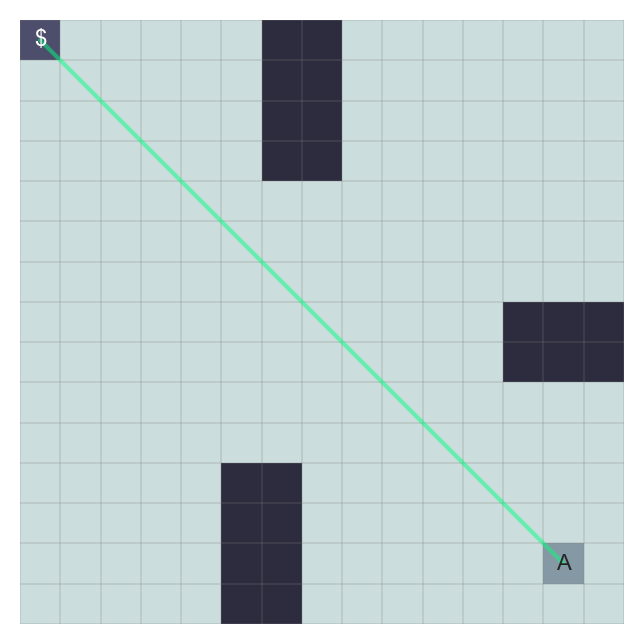

In [19]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 200

# Taking the first step (need to calculate the policy)
observation, reward, done, info =  agent1.take_action()

In [146]:
# Note you can run this cell multiple times to see the animation

# disable inline mode to see the animation
%matplotlib
plt.rcParams['figure.dpi'] = 200

# Taking the rest of the steps (No re-calculation of the policy)
while not done:
    observation, reward, done, info = agent1.take_action()
    plt.pause(0.3) # pause for 1 second between frames
done = False
environment1.reset()

Using matplotlib backend: TkAgg


### A ) 
Base parameters

Iteration: 1, stable: False
Iteration: 2, stable: False
Iteration: 3, stable: False
Iteration: 4, stable: False
Iteration: 5, stable: False
Iteration: 6, stable: True
Policy Converged after 6 iterations


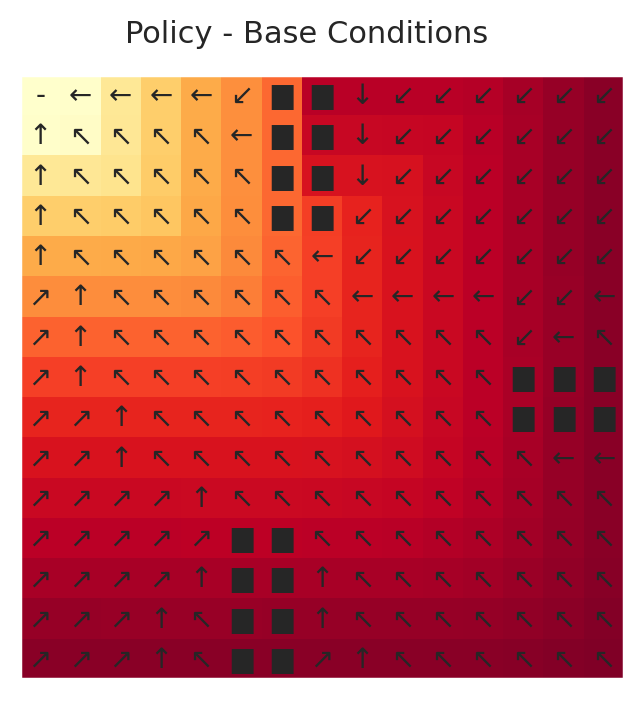

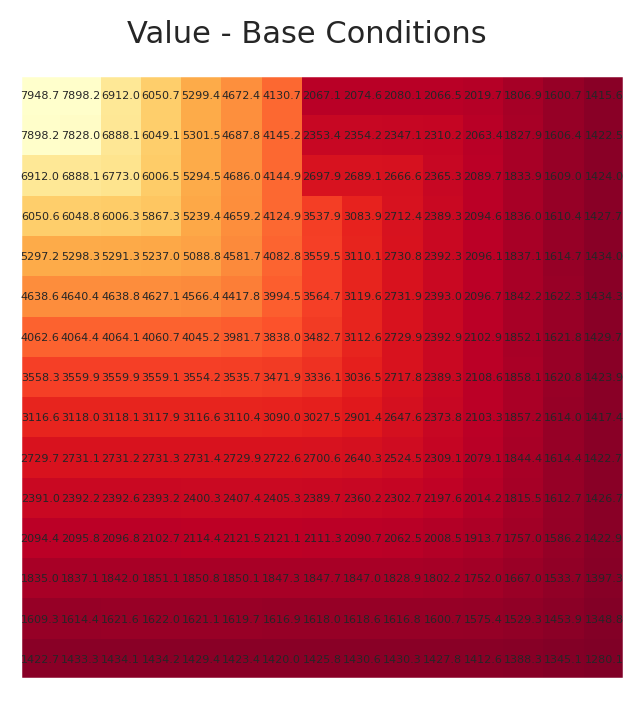

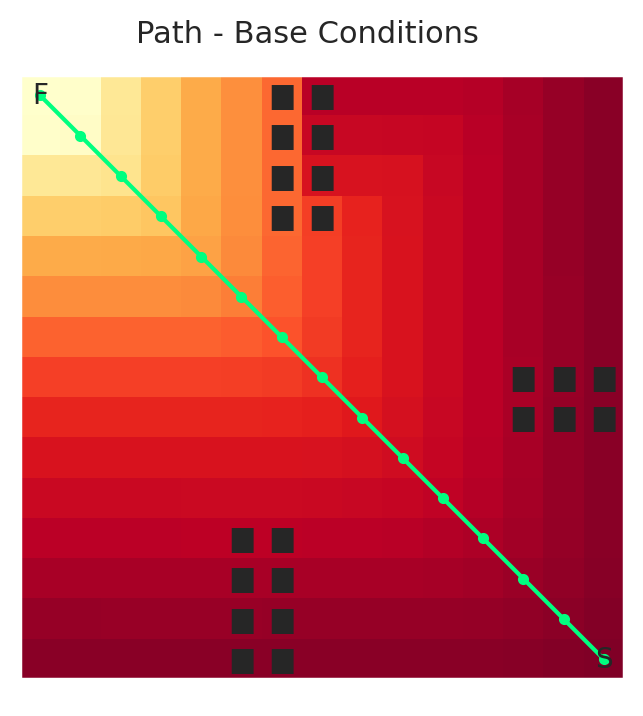

In [152]:
%matplotlib inline

np.random.seed(1)

# Hyperparameters
actionPrice=-0.01
goalReward=1000
punish=-1
theta=1
discount=0.9

# Model
environment2 = Environment(actionPrice=actionPrice, goalReward=goalReward, punish=punish, obstacles=obstacles)
agent2 = Agent(environment=environment2, theta=theta, discount=discount, algorithm='policy_iteration')

# Perform policy iteration
agent2.policy_iteration(debug=True)

# Visualization and pathfinding
visualize_policy(agent2.V, agent2.policy, title="Base Conditions")
visualize_value_function(agent2.V, title="Base Conditions")
path2 = visualize_path(agent2.V, agent2.policy, title="Base Conditions")

### B )
No Friction parameters

Iteration: 1, stable: False
Iteration: 2, stable: False
Iteration: 3, stable: False
Iteration: 4, stable: False
Iteration: 5, stable: False
Iteration: 6, stable: True
Policy Converged after 6 iterations


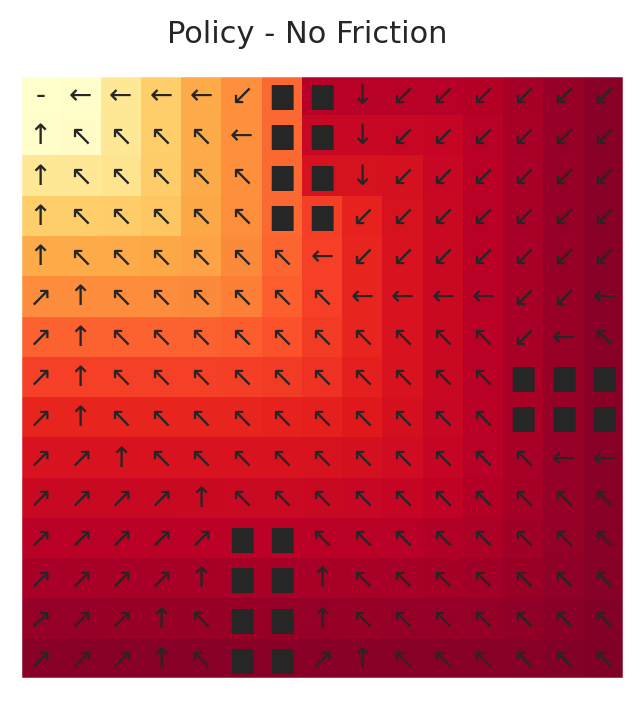

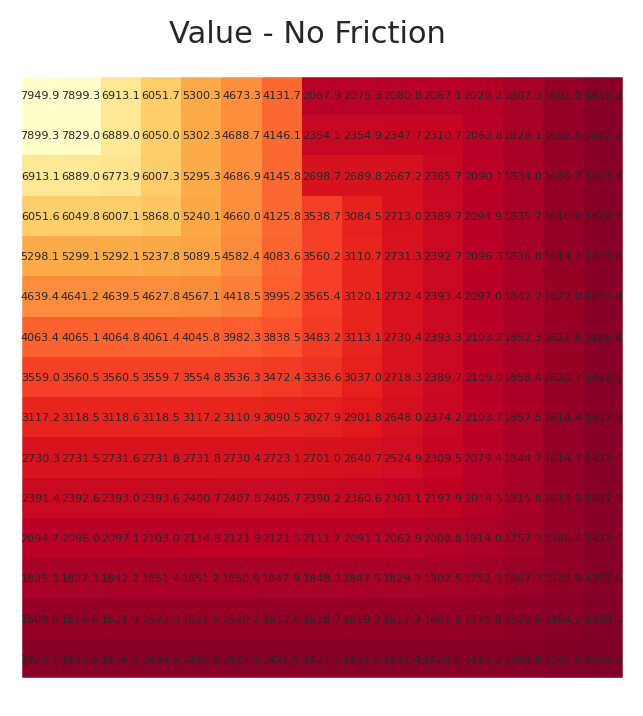

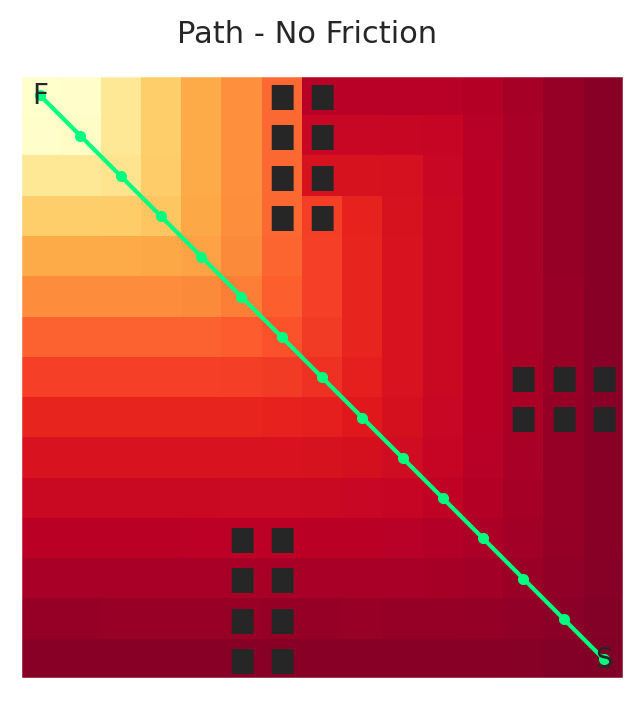

In [153]:
np.random.seed(1)

# Hyperparameters
actionPrice=0
goalReward=1000
punish=-0.01
theta=1
discount=0.9

# Model
environment3 = Environment(actionPrice=actionPrice, goalReward=goalReward, punish=punish, obstacles=obstacles)
agent3 = Agent(environment=environment3, theta=theta, discount=discount, algorithm='policy_iteration')

# Perform policy iteration
agent3.policy_iteration(debug=True)

# Visualization and pathfinding
visualize_policy(agent3.V, agent3.policy, title="No Friction")
visualize_value_function(agent3.V, title="No Friction")
path3 = visualize_path(agent3.V, agent3.policy, title="No Friction")

### C )

Iteration: 1, stable: False
Iteration: 2, stable: False
Iteration: 3, stable: False
Iteration: 4, stable: False
Iteration: 5, stable: False
Iteration: 6, stable: False
Iteration: 7, stable: True
Policy Converged after 7 iterations


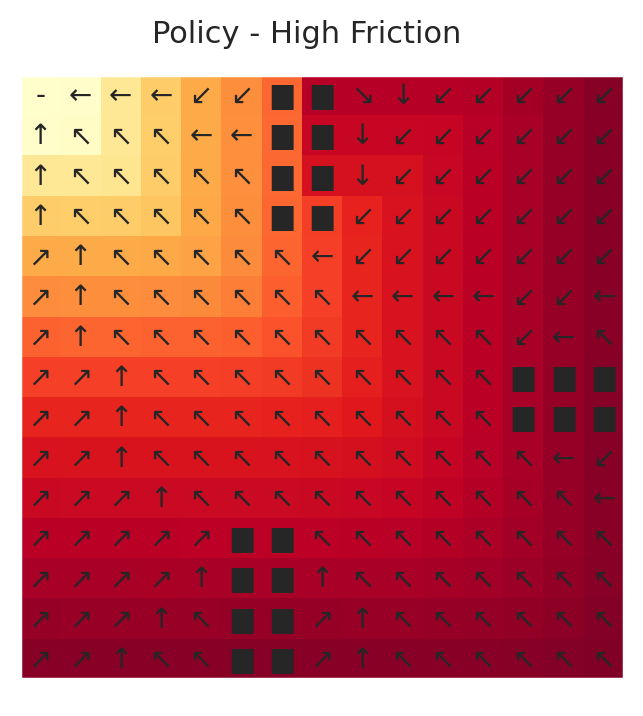

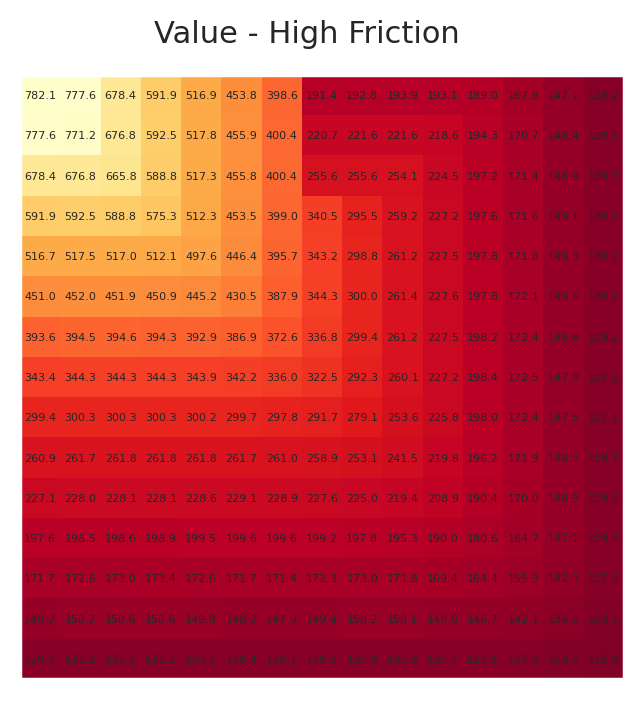

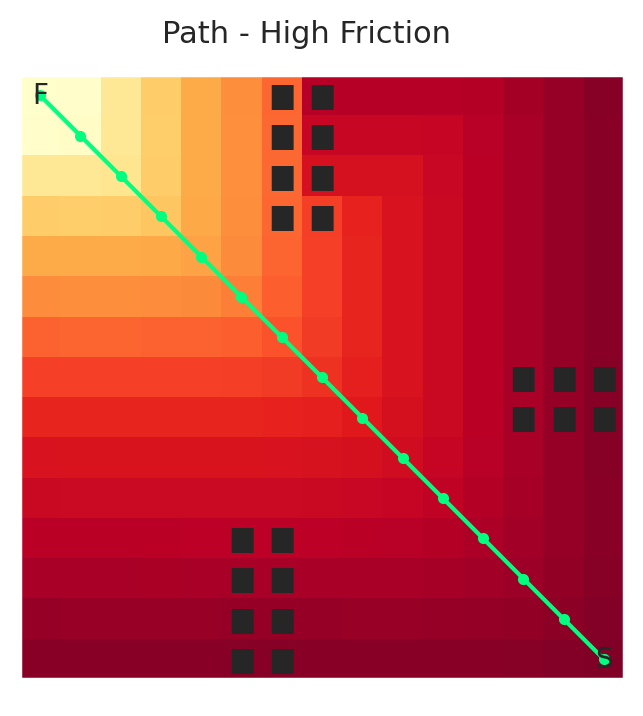

In [151]:
np.random.seed(1)

# Hyperparameters
actionPrice=-1
goalReward=100
punish=-10
theta=1
discount=0.9

# Model
environment4 = Environment(actionPrice=actionPrice, goalReward=goalReward, punish=punish, obstacles=obstacles)
agent4 = Agent(environment=environment4, theta=theta, discount=discount, algorithm='policy_iteration')

# Perform policy iteration
agent4.policy_iteration(debug=True)

# Visualization and pathfinding
visualize_policy(agent4.V, agent4.policy, title="High Friction")
visualize_value_function(agent4.V, title="High Friction")
path4 = visualize_path(agent4.V, agent4.policy, title="High Friction")

### D)
Best Parameters

In [ ]:
%matplotlib inline

np.random.seed(1)

# Hyperparameters
actionPrice=-0.01
goalReward=1000
punish=-1
theta=1
discount=0.9

# Model
environment2 = Environment(actionPrice=actionPrice, goalReward=goalReward, punish=punish, obstacles=obstacles)
agent2 = Agent(environment=environment2, theta=theta, discount=discount, algorithm='policy_iteration')

# Perform policy iteration
agent2.policy_iteration(debug=True)

# Visualization and pathfinding
visualize_policy(agent2.V, agent2.policy, title="Base Conditions")
visualize_value_function(agent2.V, title="Base Conditions")
path2 = visualize_path(agent2.V, agent2.policy, title="Base Conditions")

### E)
Value iteration with best parameters

Iteration: 1  | 1920.429 ms | delta: 79.79999999999995
Iteration: 2  | 1922.396 ms | delta: 70.8530625
Iteration: 3  | 1978.479 ms | delta: 63.40473703125005
Iteration: 4  | 1940.982 ms | delta: 56.99864450039061
Iteration: 5  | 1911.697 ms | delta: 51.255868489795944
Iteration: 6  | 1920.019 ms | delta: 46.11697430209716
Iteration: 7  | 1926.171 ms | delta: 41.49870480069205
Iteration: 8  | 1962.911 ms | delta: 37.34631837586926
Iteration: 9  | 1950.706 ms | delta: 33.61052719894769
Iteration: 10  | 2005.193 ms | delta: 30.248986791654545
Iteration: 11  | 1911.295 ms | delta: 27.223866149531375
Iteration: 12  | 1918.149 ms | delta: 24.5013818516976
Iteration: 13  | 1922.841 ms | delta: 22.051199112291783
Iteration: 14  | 1910.133 ms | delta: 19.84605912092968
Iteration: 15  | 1925.456 ms | delta: 17.86144399781199
Iteration: 16  | 1921.059 ms | delta: 16.075295387359347
Iteration: 17  | 1939.902 ms | delta: 14.467763904972117
Iteration: 18  | 1954.643 ms | delta: 13.020986617263588
It

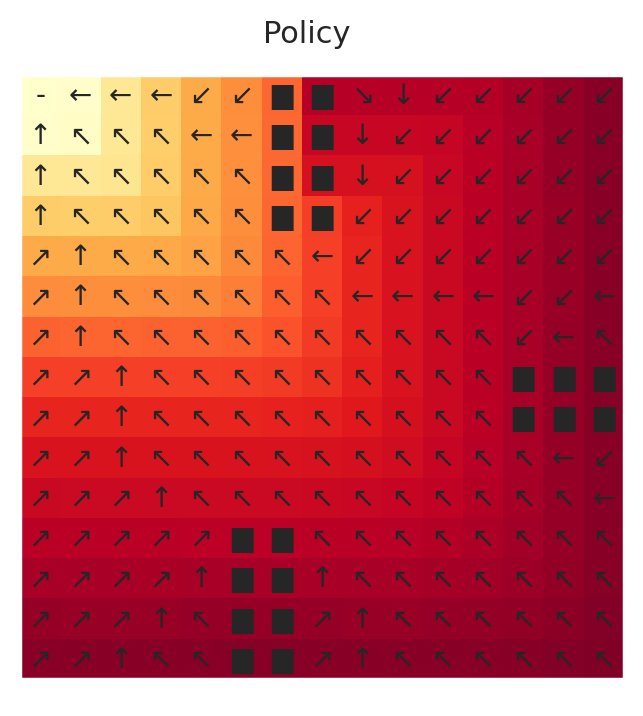

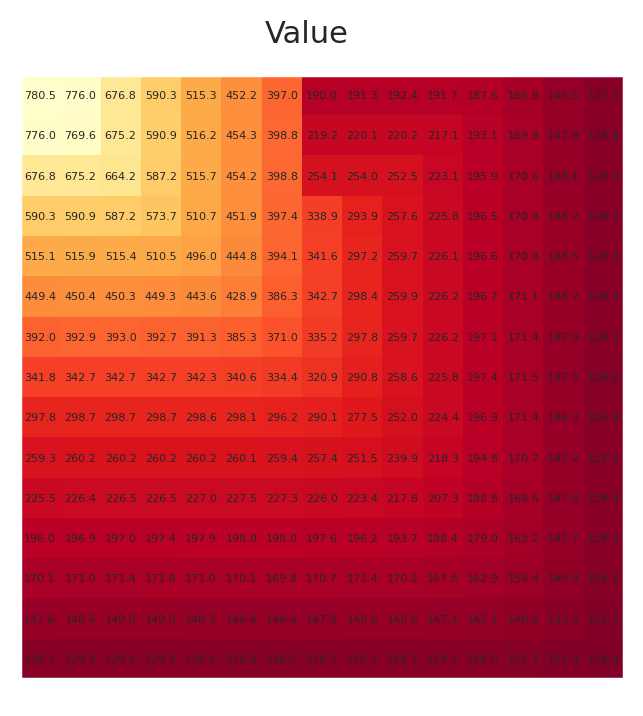

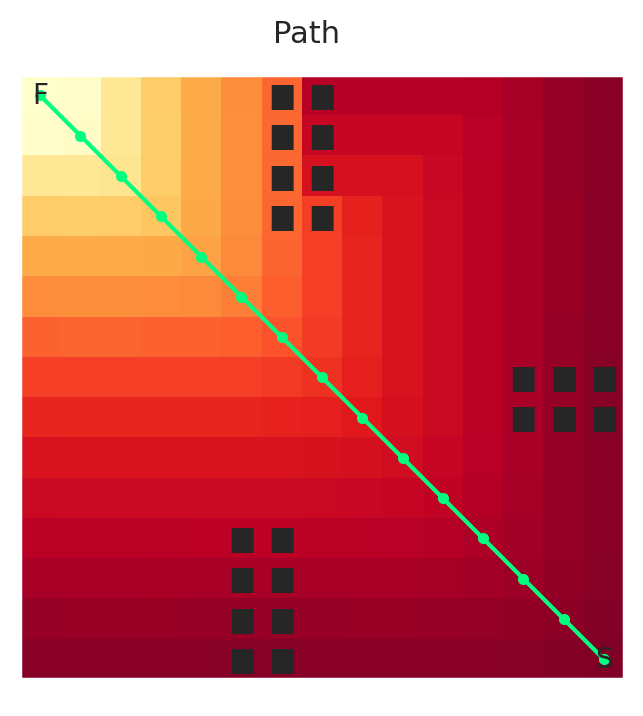

In [154]:
np.random.seed(1)

# Hyperparameters
actionPrice=-1
goalReward=100
punish=-10
theta=0.2
discount=0.9

# Model
environment5 = Environment(actionPrice=actionPrice, goalReward=goalReward, punish=punish, obstacles=obstacles)
agent5 = Agent(environment=environment5, theta=theta, discount=discount, algorithm='value_iteration')

# Perform value iteration
agent5.value_iteration(debug=True, debug_iter_time=True)

# Visualization and pathfinding
visualize_policy(agent5.V, agent5.policy)
visualize_value_function(agent5.V)
path5 = visualize_path(agent5.V, agent5.policy)

### Testing

In [ ]:
%matplotlib inline

np.random.seed(1)

# Hyperparameters
actionPrice=-0.01
goalReward=1000
punish=-1
theta=1
discount=0.9

# Model
environment5 = Environment(actionPrice=actionPrice, goalReward=goalReward, punish=punish, obstacles=obstacles)
agent5 = Agent(environment=environment5, theta=theta, discount=discount, algorithm='policy_iteration')

# Perform policy iteration
agent5.policy_iteration(debug=True)

# Visualization and pathfinding
visualize_policy(agent5.V, agent5.policy, title="Base Conditions")
visualize_value_function(agent5.V, title="Base Conditions")
path5 = visualize_path(agent5.V, agent5.policy, title="Base Conditions")